In [1]:
model_file = "HG00420_manta_model.keras"
windows_file = "HG00420_windows_en.npz"

In [2]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

In [3]:
import numpy as np
npzfile = np.load(windows_file, allow_pickle=True)
X = npzfile['data']
labels = npzfile['labels']
labels = labels.item()

In [4]:
# Import DeepExplain
from deepexplain.tensorflow import DeepExplain

In [5]:
from tensorflow.keras.models import load_model

In [6]:
model = load_model(model_file)

2021-08-11 12:09:56.531531: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-08-11 12:09:56.560736: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:196] None of the MLIR optimization passes are enabled (registered 0 passes)


In [17]:
from tensorflow.compat.v1.keras import backend as K
from tensorflow.compat.v1.keras.models import Model
from tensorflow.keras.utils import to_categorical

In [84]:
%%time
with DeepExplain(session=K.get_session()) as de:  # <-- init DeepExplain context
    # Need to reconstruct the graph in DeepExplain context, using the same weights.
    # With Keras this is very easy:
    # 1. Get the input tensor to the original model
    input_tensor = model.layers[0].input
    
    # 2. We now target the output of the last dense layer (pre-softmax)
    # To do so, create a new model sharing the same layers untill the last dense (index -2)
    fModel = Model(inputs=input_tensor, outputs = model.layers[-2].output)
    target_tensor = fModel(input_tensor)
    
    svtype = 'DEL'
    mapclasses = {svtype: 0, 'no' + svtype: 1}
    y = np.array([mapclasses[i] for i in labels.values()])
    y_binary = to_categorical(y, num_classes=len(mapclasses.keys()))
    
    idx_class = [i for i,v in enumerate(y) if v == 1]
    ys = y_binary[idx_class][0:10]
    xs = X[idx_class][0:10]
    
    attributions_gradin = de.explain('grad*input', target_tensor, input_tensor, xs, ys=ys)
    attributions_sal   = de.explain('saliency', target_tensor, input_tensor, xs, ys=ys)
    attributions_ig    = de.explain('intgrad', target_tensor, input_tensor, xs, ys=ys)
    attributions_dl    = de.explain('deeplift', target_tensor, input_tensor, xs, ys=ys)
    attributions_elrp  = de.explain('elrp', target_tensor, input_tensor, xs, ys=ys)
    #attributions_occ   = de.explain('occlusion', target_tensor, input_tensor, xs, ys=ys)
    
    # Compare Gradient * Input with approximate Shapley Values
    # Note1: Shapley Value sampling with 100 samples per feature (78400 runs) takes a couple of minutes on a GPU.
    # Note2: 100 samples are not enough for convergence, the result might be affected by sampling variance
    #attributions_sv     = de.explain('shapley_sampling', target_tensor, input_tensor, xs, ys=ys, samples=100)

CPU times: user 14.1 s, sys: 3.16 s, total: 17.2 s
Wall time: 14.6 s


In [79]:
from skimage import feature, transform
import numpy as np
import matplotlib.pyplot as plt


def plot(data, xi=None, cmap='RdBu_r', axis=plt, percentile=100, dilation=3.0, alpha=0.8):
    dx, dy = 0.05, 0.05
    xx = np.arange(0.0, data.shape[1], dx)
    yy = np.arange(0.0, data.shape[0], dy)
    xmin, xmax, ymin, ymax = np.amin(xx), np.amax(xx), np.amin(yy), np.amax(yy)
    extent = xmin, xmax, ymin, ymax
    cmap_xi = plt.get_cmap('Greys_r')
    cmap_xi.set_bad(alpha=0)
    overlay = None
    if xi is not None:
        # Compute edges (to overlay to heatmaps later)
        xi_greyscale = xi if len(xi.shape) == 2 else np.mean(xi, axis=-1)
        in_image_upscaled = transform.rescale(xi_greyscale, dilation, mode='constant')
        edges = feature.canny(in_image_upscaled).astype(float)
        edges[edges < 0.5] = np.nan
        edges[:5, :] = np.nan
        edges[-5:, :] = np.nan
        edges[:, :5] = np.nan
        edges[:, -5:] = np.nan
        overlay = edges

    abs_max = np.percentile(np.abs(data), percentile)
    abs_min = abs_max

    if len(data.shape) == 3:
        data = np.mean(data, 2)
    axis.imshow(data, extent=extent, interpolation='none', cmap=cmap, vmin=-abs_min, vmax=abs_max,
               aspect='auto')
    if overlay is not None:
        axis.imshow(overlay, extent=extent, interpolation='none', cmap=cmap_xi, alpha=alpha,
                   aspect='auto')
    axis.axis('off')
    return axis

/var/folders/2s/jd799tn17y31chbdhyvpn604000bpl/T/ipykernel_18866/3731618959.py:13: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("Greys_r").copy()
  cmap_xi.set_bad(alpha=0)


CPU times: user 1.03 s, sys: 29.7 ms, total: 1.06 s
Wall time: 1.07 s


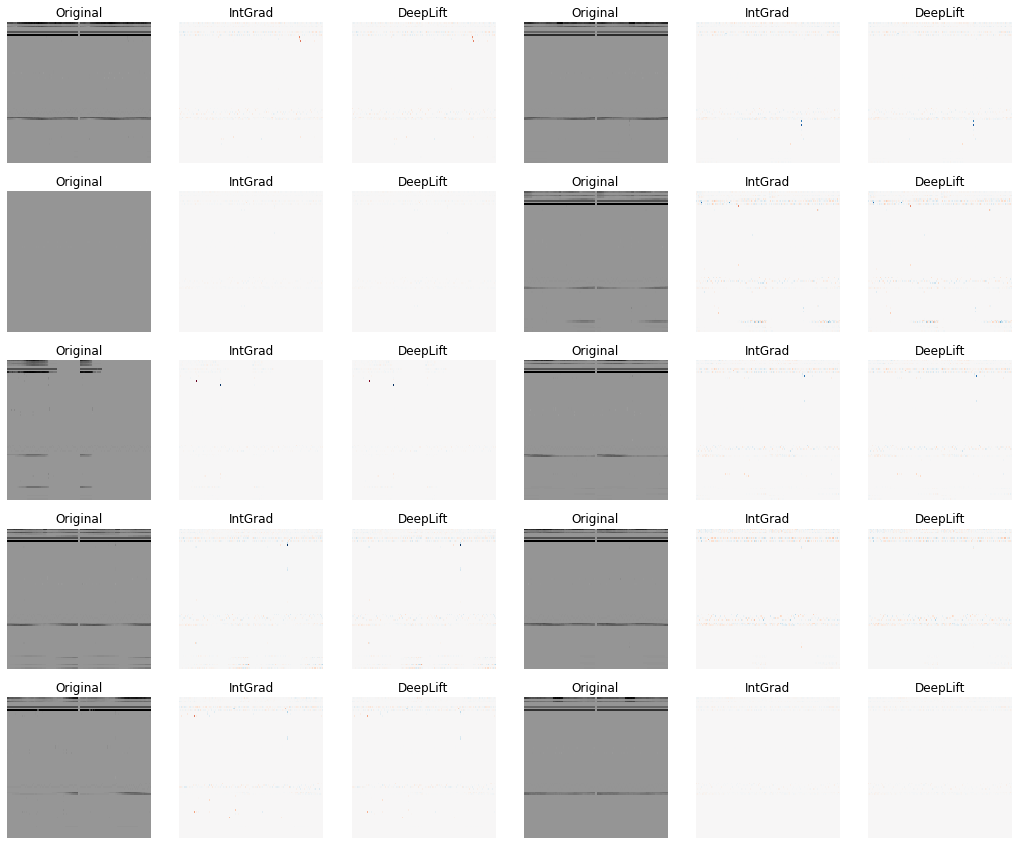

In [96]:
%%time
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
%matplotlib inline

n_cols = 6
n_rows = int(len(attributions_dl) / 2)
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(3*n_cols, 3*n_rows))

for i, (a1, a2, a3, a4, a5) in enumerate(zip(attributions_ig, attributions_dl, attributions_gradin,
                                attributions_sal, attributions_elrp)):
    row, col = divmod(i, 2)
    plot(np.transpose(xs[i]), cmap='Greys', axis=axes[row, col*3]).set_title('Original')
    plot(np.transpose(a1), xi = None, axis=axes[row,col*3+1]).set_title('IntGrad')
    plot(np.transpose(a2), xi = None, axis=axes[row,col*3+2]).set_title('DeepLift')
    #plot(np.transpose(a3), xi = None, axis=axes[row,col*3+3]).set_title('Grad*Input')
    #plot(np.transpose(a4), xi = None, axis=axes[row,col*3+1]).set_title('Saliency')
    #plot(np.transpose(a5), xi = None, axis=axes[row,col*3+2]).set_title('elrp')
plt.savefig('deepexplain_noDEL.png')